Type bag-of-words

✅ F1-score (micro): 0.5755395683453237
✅ F1-score (samples): 0.5043478260869564
🔎 Exemple de prédiction pour : 'how to create a generator in python' ➜ [('python',)]


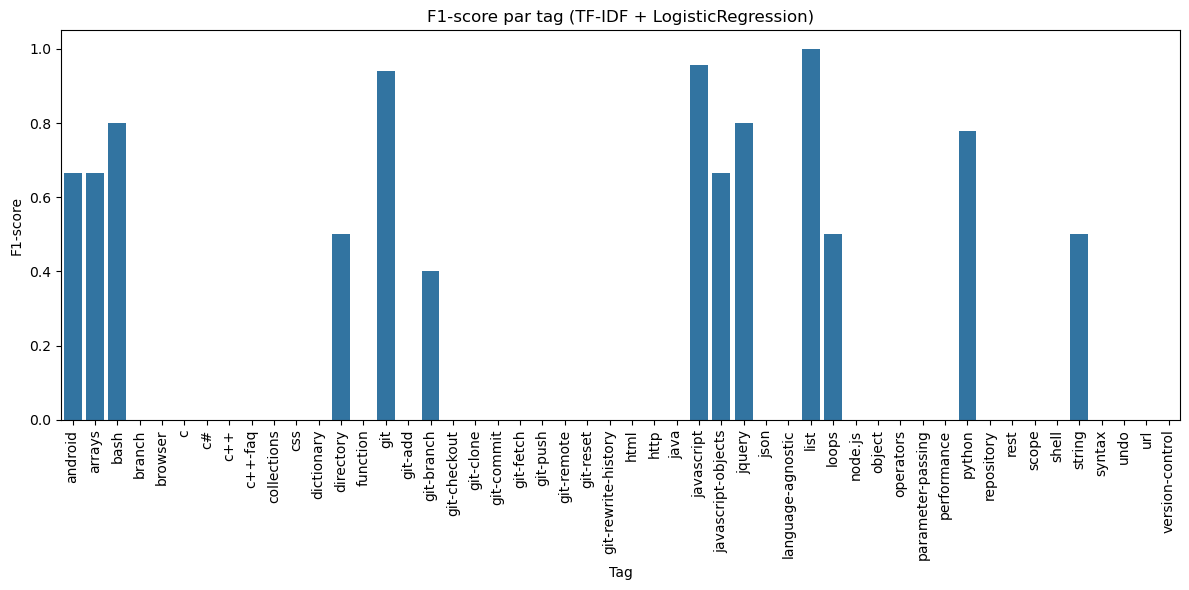

In [5]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Nettoyage texte
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

# Chargement des données
df = pd.read_csv("stack_questions_api.csv")
df['clean_title'] = df['title'].astype(str).apply(clean_text)
df['tags'] = df['tags'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Filtrer les tags les plus fréquents
all_tags = [tag for tags in df['tags'] for tag in tags]
top_tags = set([tag for tag, _ in Counter(all_tags).most_common(50)])
df['tags'] = df['tags'].apply(lambda tags: [tag for tag in tags if tag in top_tags])
df = df[df['tags'].map(len) > 0]

# Encodage des tags
X = df['clean_title']
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['tags'])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline TF-IDF + LogisticRegression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', class_weight='balanced')))
])

# Entraînement
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Évaluation
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_samples = f1_score(y_test, y_pred, average='samples')

print("✅ F1-score (micro):", f1_micro)
print("✅ F1-score (samples):", f1_samples)

# Fonction prédiction simple
def predict_tags(title):
    title_clean = clean_text(title)
    pred = pipeline.predict([title_clean])
    return mlb.inverse_transform(pred)

# Exemple de prédiction
example = "how to create a generator in python"
print(f"🔎 Exemple de prédiction pour : '{example}' ➜ {predict_tags(example)}")

# Visualisation des scores F1 par tag
report = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True, zero_division=0)
f1_scores = {label: score['f1-score'] for label, score in report.items() if label in mlb.classes_}

plt.figure(figsize=(12, 6))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()))
plt.xticks(rotation=90)
plt.title("F1-score par tag (TF-IDF + LogisticRegression)")
plt.ylabel("F1-score")
plt.xlabel("Tag")
plt.tight_layout()
plt.show()


Word2Vec

In [4]:
import numpy as np
import pandas as pd
import re
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, classification_report
from collections import Counter

# Chargement des données
df = pd.read_csv("stack_questions_api.csv")

# Nettoyage
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

df['clean_title'] = df['title'].astype(str).apply(clean_text)
df['tags'] = df['tags'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Filtrage des tags les plus fréquents
all_tags = [tag for tags in df['tags'] for tag in tags]
top_tags = set([tag for tag, count in Counter(all_tags).most_common(50)])
df['tags'] = df['tags'].apply(lambda tags: [tag for tag in tags if tag in top_tags])
df = df[df['tags'].map(len) > 0]

# Binarisation des tags
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['tags'])

# Tokenisation
df['tokens'] = df['clean_title'].apply(lambda x: x.split())

# Entraînement Word2Vec
w2v_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4, seed=42)

# Vectorisation des phrases
def vectorize_sentence(tokens, model, vector_size=100):
    valid_tokens = [token for token in tokens if token in model.wv]
    if not valid_tokens:
        return np.zeros(vector_size)
    return np.mean([model.wv[token] for token in valid_tokens], axis=0)

X_w2v = df['tokens'].apply(lambda tokens: vectorize_sentence(tokens, w2v_model, vector_size=100))
X_w2v = np.vstack(X_w2v.values)

# Séparation train/test
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

# Entraînement du classifieur
clf_w2v = OneVsRestClassifier(LogisticRegression(solver='liblinear', class_weight='balanced'))
clf_w2v.fit(X_train_w2v, y_train_w2v)

# Prédictions
y_pred_w2v = clf_w2v.predict(X_test_w2v)

# Évaluation
f1_micro = f1_score(y_test_w2v, y_pred_w2v, average="micro")
f1_samples = f1_score(y_test_w2v, y_pred_w2v, average="samples")

print("✅ Word2Vec - F1-score (micro):", f1_micro)
print("✅ Word2Vec - F1-score (samples):", f1_samples)

# Exploration du modèle Word2Vec
print("\n🔍 Exemples de similarités dans Word2Vec :")
for word in ["terminal", "python", "shell"]:
    if word in w2v_model.wv:
        print(f"\nTop 5 mots similaires à '{word}' :")
        for similar_word, similarity in w2v_model.wv.most_similar(word, topn=5):
            print(f"  - {similar_word} ({similarity:.2f})")
    else:
        print(f"Mot '{word}' non trouvé dans le vocabulaire Word2Vec.")

✅ Word2Vec - F1-score (micro): 0.27325581395348836
✅ Word2Vec - F1-score (samples): 0.2591708092986865

🔍 Exemples de similarités dans Word2Vec :

Top 5 mots similaires à 'terminal' :
  - upload (0.26)
  - body (0.24)
  - soft (0.24)
  - map (0.22)
  - value (0.22)

Top 5 mots similaires à 'python' :
  - my (0.36)
  - generate (0.29)
  - decimal (0.26)
  - initialization (0.26)
  - difference (0.26)

Top 5 mots similaires à 'shell' :
  - insensitive (0.33)
  - checkbox (0.25)
  - author (0.24)
  - invalid (0.24)
  - get (0.23)
